In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter 

#### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

#### Import data

In [3]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [15]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['forpr_sjc3','backvs_sjc3']
         #'backadm_sjc3','forgulf_sjc3']
        #  'forvs_haro3','backpr_haro3','backgulf_haro3']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2017,12,10)
enddate = dt.datetime(2021,12,27)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t50/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                print(date)
                pass


28may18
28may18
28may18
28may18
28may18
28may18
28may18
28may18
28may18


In [16]:
dict_secdata = {}
sectionnum = [0,1,2,3,4,5,6,7,8]

for file in files:
     
    if file not in dict_secdata:
        dict_secdata[file] = {}
    
    for section in sectionnum:
        
        if section not in dict_secdata[file]:
            
            dict_secdata[file][section] = {}
            
        for date in dicts[file].keys():
            
            if section not in dict_secdata[file]:
            
                dict_secdata[file][section][date] = {}
            
            dict_secdata[file][section][date] = get_secdata(dicts[file][date],section)

#### Shifting functions

In [6]:
def shift_time(dfr,dfr_age,datelist,base,factor):
    shifted_time = [date + dt.timedelta(days=base+factor*dfr_age[i]/24) for i,date in enumerate(datelist)]
    dfr = pd.DataFrame({'Transport':dfr.values,'Shifted_Time': shifted_time},index=dfr.index)
    return dfr

def merge(dfr,dfr2):
    """Aligns shifted dateframes to calculate correlation

    Args:
        dfr : Forward dataframe
        dfr2 (_type_): Backward dataframe

    Returns:
        _type_: Aligned, shifted dataframes and correlation between the 2.
    """
    
    oidx = dfr.index
    ndfr = dfr.set_index('Shifted_Time')
    nidx = ndfr.index
    
    step1 = ndfr.reindex(nidx.union(oidx)) # Creates dataframe with row of each old and new index ( no overlap - 128 rows now)
    step2 = step1.sort_index() # Sorts into chronological order
    step3 = step2.interpolate(axis=0) # Interpolates in between (since dates dont line up)
    fdfr = step3
    
    #Same for 2nd dataframe
    oidx2 = dfr2.index
    ndfr2 = dfr2.set_index('Shifted_Time')
    nidx2 = ndfr2.index
    
    step1 = ndfr2.reindex(nidx2.union(oidx2))
    step2 = step1.sort_index()
    step3 = step2.interpolate(axis=0)
    fdfr2 = step3
    
    corr = fdfr.Transport.corr(fdfr2.Transport) #Correlation ignores nan values
    
    avg = 0.5*(fdfr.Transport + fdfr2.Transport)
    return fdfr,fdfr2,corr,avg

##### PR to VS

[8.8817842e-16] [0.3]
0.7413706843312089


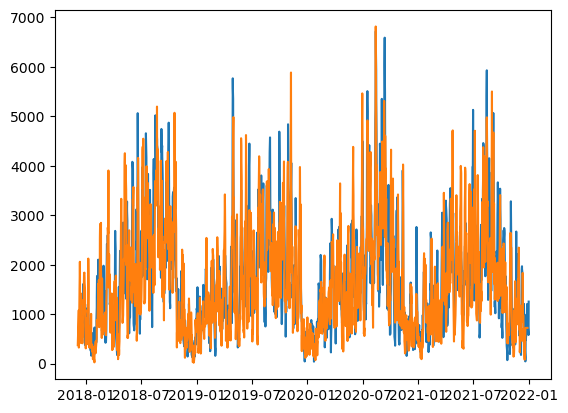

In [17]:
dates = []
datelist_vs_prtovs = []
date = dt.datetime(2017,12,10)
enddate = dt.datetime(2021,12,27)

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs_prtovs.append(date)
    date+=dt.timedelta(days=1)

datelist_vs_prtovs.pop(169)

PRtoVS_sjcl = sectransp_2018['forpr_sjc3'][5]
PRtoVS_sjcbl = sectransp_2018['backvs_sjc3'][5]

PRtoVS_sjc = pd.Series(PRtoVS_sjcl,index=datelist_vs_prtovs)
PRtoVS_sjcb = pd.Series(PRtoVS_sjcbl,index=datelist_vs)

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoVS_sjc,age_2018['forpr_sjc3'][5],datelist_vs_prtovs,base,factor)
        dfr2 = shift_time(PRtoVS_sjcb,age_2018['backvs_sjc3'][5],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

PRtoVS_sjc_sh = shift_time(PRtoVS_sjc,age_2018['forpr_sjc3'][5],datelist_vs_prtovs,base_adm[0],factor_adm[0])
PRtoVS_sjcb_sh = shift_time(PRtoVS_sjcb,age_2018['backvs_sjc3'][5],datelist_vs,-base_adm[0],-factor_adm[0])

PRtoVS_sjc_m,PRtoVS_sjcb_m,c,PRtoVS_sjc_avg = merge(PRtoVS_sjc_sh,PRtoVS_sjcb_sh)
print(c)

plt.plot(PRtoVS_sjc_m.Transport)
plt.plot(PRtoVS_sjcb_m.Transport)

#### PR to adm

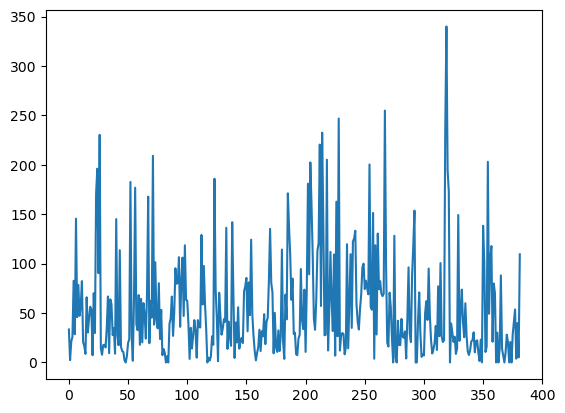

In [ ]:
PRtoadm_sjcl = sectransp_2018['forpr_sjc3'][2]
PRtoadm_sjcbl = sectransp_2018['backadm_sjc3'][5]

# PRtoadm_sjc = pd.Series(PRtoadm_sjcl,index=datelist_vs_prtovs)
# PRtoadm_sjcb = pd.Series(PRtoadm_sjcbl,index=datelist_vs)

# # Loop through different base and factors to find which combination maximizes the correlation

# factor_arr = np.arange(-1,1,0.05)
# base_arr = np.arange(-1,1,0.05)

# corr_arr = np.zeros([len(base_arr),len(factor_arr)])

# for i,base in enumerate(base_arr):
#     for j,factor in enumerate(factor_arr):
#         dfr1 = shift_time(PRtoadm_sjc,age_2018['forpr_sjc3'][2],datelist_vs_prtovs,base,factor)
#         dfr2 = shift_time(PRtoadm_sjcb,age_2018['backadm_sjc3'][2],datelist_vs,-base,-factor)
#         dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        
# i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

# base_adm = base_arr[i_base_adm]
# factor_adm = factor_arr[i_factor_adm]

# print(base_adm,factor_adm)

# PRtoadm_sjc_sh = shift_time(PRtoadm_sjc,age_2018['forpr_sjc3'][2],datelist_vs_prtovs,base_adm[0],factor_adm[0])
# PRtoadm_sjcb_sh = shift_time(PRtoadm_sjcb,age_2018['backadm_sjc3'][2],datelist_vs,-base_adm[0],-factor_adm[0])

# PRtoadm_sjc_m,PRtoadm_sjcb_m,c,PRtoadm_sjc_avg = merge(PRtoadm_sjc_sh,PRtoadm_sjcb_sh)
# print(c)

# plt.plot(PRtoadm_sjc_m.Transport)
# plt.plot(PRtoadm_sjcb_m.Transport)

plt.plot(PRtoadm_sjcl)

#### Gulf to VS

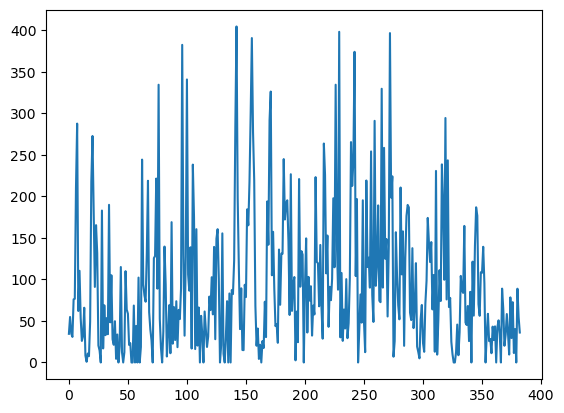

In [ ]:
GulftoVS_sjcl = sectransp_2018['forgulf_sjc3'][7]
GulftoVS_sjcbl = sectransp_2018['backvs_sjc3'][7]

# GulftoVS_sjc = pd.Series(GulftoVS_sjcl,index=datelist_vs)
# GulftoVS_sjcb = pd.Series(GulftoVS_sjcbl,index=datelist_vs)

# # Loop through different base and factors to find which combination maximizes the correlation

# factor_arr = np.arange(-1,1,0.05)
# base_arr = np.arange(-1,1,0.05)

# corr_arr = np.zeros([len(base_arr),len(factor_arr)])

# for i,base in enumerate(base_arr):
#     for j,factor in enumerate(factor_arr):
#         dfr1 = shift_time(GulftoVS_sjc,age_2018['forgulf_sjc3'][7],datelist_vs,base,factor)
#         dfr2 = shift_time(GulftoVS_sjcb,age_2018['backvs_sjc3'][7],datelist_vs,-base,-factor)
#         dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        
# i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

# base_adm = base_arr[i_base_adm]
# factor_adm = factor_arr[i_factor_adm]

# print(base_adm,factor_adm)

# GulftoVS_sjc_sh = shift_time(GulftoVS_sjc,age_2018['forgulf_sjc3'][7],datelist_vs,base_adm[0],factor_adm[0])
# GulftoVS_sjcb_sh = shift_time(GulftoVS_sjcb,age_2018['backvs_sjc3'][7],datelist_vs,-base_adm[0],-factor_adm[0])

# GulftoVS_sjc_m,GulftoVS_sjcb_m,c,GulftoVS_sjc_avg = merge(GulftoVS_sjc_sh,GulftoVS_sjcb_sh)
# print(c)

# plt.plot(GulftoVS_sjc_m.Transport)
# plt.plot(GulftoVS_sjcb_m.Transport)

plt.plot(GulftoVS_sjcbl)

#### Gulf to adm

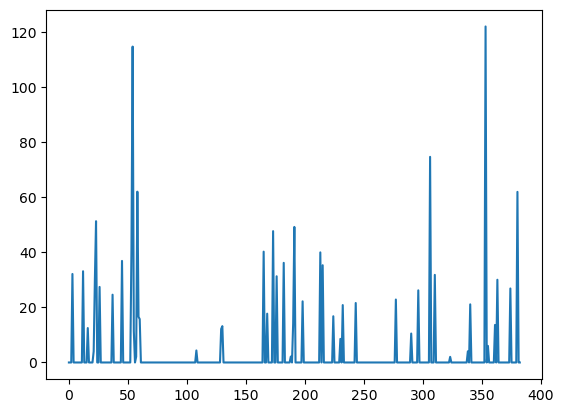

In [ ]:
Gulftoadm_sjcl = sectransp_2018['forgulf_sjc3'][2]
Gulftoadm_sjcbl = sectransp_2018['backadm_sjc3'][7]

# Gulftoadm_sjc = pd.Series(Gulftoadm_sjcl,index=datelist_vs)
# Gulftoadm_sjcb = pd.Series(Gulftoadm_sjcbl,index=datelist_vs)

# # Loop through different base and factors to find which combination maximizes the correlation

# factor_arr = np.arange(-1,1,0.05)
# base_arr = np.arange(-1,1,0.05)

# corr_arr = np.zeros([len(base_arr),len(factor_arr)])

# for i,base in enumerate(base_arr):
#     for j,factor in enumerate(factor_arr):
#         dfr1 = shift_time(Gulftoadm_sjc,age_2018['forgulf_sjc3'][2],datelist_vs,base,factor)
#         dfr2 = shift_time(Gulftoadm_sjcb,age_2018['backadm_sjc3'][7],datelist_vs,-base,-factor)
#         dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        
# i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

# base_adm = base_arr[i_base_adm]
# factor_adm = factor_arr[i_factor_adm]

# print(base_adm,factor_adm)

# Gulftoadm_sjc_sh = shift_time(Gulftoadm_sjc,age_2018['forgulf_sjc3'][5],datelist_vs,base_adm[0],factor_adm[0])
# Gulftoadm_sjcb_sh = shift_time(Gulftoadm_sjcb,age_2018['backvs_sjc3'][7],datelist_vs,-base_adm[0],-factor_adm[0])

# Gulftoadm_sjc_m,Gulftoadm_sjcb_m,c,Gulftoadm_sjc_avg = merge(Gulftoadm_sjc_sh,Gulftoadm_sjcb_sh)
# print(c)

# plt.plot(Gulftoadm_sjc_m.Transport)
# plt.plot(Gulftoadm_sjcb_m.Transport)

plt.plot(Gulftoadm_sjcbl)

#### PRtoVS 2018

[0.3] [0.35]
0.7737901180696256


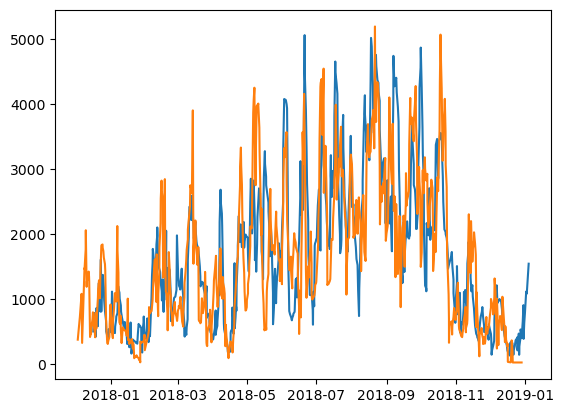

In [18]:
PRtovs2018_sjcl = sectransp_2018['forpr_sjc3'][5][0:385]
PRtovs2018_sjcbl = sectransp_2018['backvs_sjc3'][5][0:385]

PRtovs2018_sjc = pd.Series(PRtovs2018_sjcl,index=datelist_vs_prtovs[0:385])
PRtovs2018_sjcb = pd.Series(PRtovs2018_sjcbl,index=datelist_vs[0:385])

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2018_sjc,age_2018['forpr_sjc3'][5][0:385],datelist_vs_prtovs[0:385],base,factor)
        dfr2 = shift_time(PRtovs2018_sjcb,age_2018['backvs_sjc3'][5][0:385],datelist_vs[0:385],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
            
i_base,i_factor = np.where(corr_arr==np.max(corr_arr))

base = base_arr[i_base]
factor = factor_arr[i_factor]

print(base,factor)

PRtovs2018_sjc_sh = shift_time(PRtovs2018_sjc,age_2018['forpr_sjc3'][5][0:385],datelist_vs_prtovs[0:385],base[0],factor[0])
PRtovs2018_sjcb_sh = shift_time(PRtovs2018_sjcb,age_2018['backvs_sjc3'][5][0:385],datelist_vs[0:385],-base[0],-factor[0])

PRtovs2018_sjc_m,PRtovs2018_sjcb_m,c,PRtovs2018_sjc_avg = merge(PRtovs2018_sjc_sh,PRtovs2018_sjcb_sh)
print(c)

plt.plot(PRtovs2018_sjc_m.Transport)
plt.plot(PRtovs2018_sjcb_m.Transport)

#### PRtoVS 2019

[-0.35] [0.35]
0.6612297231784173


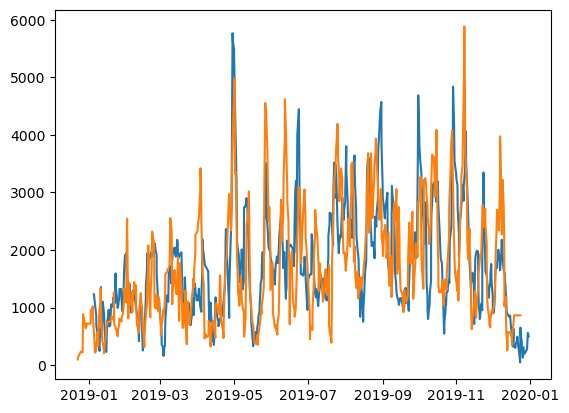

In [20]:
PRtovs2019_sjcl = sectransp_2018['forpr_sjc3'][5][385:745]
PRtovs2019_sjcbl = sectransp_2018['backvs_sjc3'][5][385:745]

PRtovs2019_sjc = pd.Series(PRtovs2019_sjcl,index=datelist_vs_prtovs[385:745])
PRtovs2019_sjcb = pd.Series(PRtovs2019_sjcbl,index=datelist_vs[385:745])

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2019_sjc,age_2018['forpr_sjc3'][5][385:745],datelist_vs_prtovs[385:745],base,factor)
        dfr2 = shift_time(PRtovs2019_sjcb,age_2018['backvs_sjc3'][5][385:745],datelist_vs[385:745],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
            
i_base,i_factor = np.where(corr_arr==np.max(corr_arr))

base = base_arr[i_base]
factor = factor_arr[i_factor]

print(base,factor)

PRtovs2019_sjc_sh = shift_time(PRtovs2019_sjc,age_2018['forpr_sjc3'][5][385:745],datelist_vs_prtovs[385:745],base[0],factor[0])
PRtovs2019_sjcb_sh = shift_time(PRtovs2019_sjcb,age_2018['backvs_sjc3'][5][385:745],datelist_vs[385:745],-base[0],-factor[0])

PRtovs2019_sjc_m,PRtovs2019_sjcb_m,c,PRtovs2019_sjc_avg = merge(PRtovs2019_sjc_sh,PRtovs2019_sjcb_sh)
print(c)

plt.plot(PRtovs2019_sjc_m.Transport)
plt.plot(PRtovs2019_sjcb_m.Transport)

#### PRtoVS 2020

[-0.3] [0.35]
0.8109823297625173


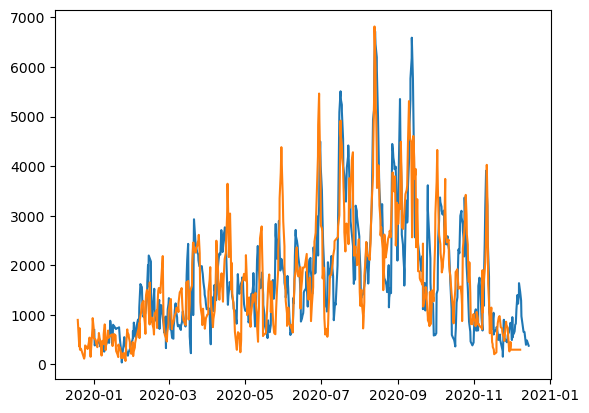

In [21]:
PRtovs2020_sjcl = sectransp_2018['forpr_sjc3'][5][745:1095]
PRtovs2020_sjcbl = sectransp_2018['backvs_sjc3'][5][745:1095]

PRtovs2020_sjc = pd.Series(PRtovs2020_sjcl,index=datelist_vs_prtovs[745:1095])
PRtovs2020_sjcb = pd.Series(PRtovs2020_sjcbl,index=datelist_vs[745:1095])

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2020_sjc,age_2018['forpr_sjc3'][5][745:1095],datelist_vs_prtovs[745:1095],base,factor)
        dfr2 = shift_time(PRtovs2020_sjcb,age_2018['backvs_sjc3'][5][745:1095],datelist_vs[745:1095],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
            
i_base,i_factor = np.where(corr_arr==np.max(corr_arr))

base = base_arr[i_base]
factor = factor_arr[i_factor]

print(base,factor)

PRtovs2020_sjc_sh = shift_time(PRtovs2020_sjc,age_2018['forpr_sjc3'][5][745:1095],datelist_vs_prtovs[745:1095],base[0],factor[0])
PRtovs2020_sjcb_sh = shift_time(PRtovs2020_sjcb,age_2018['backvs_sjc3'][5][745:1095],datelist_vs[745:1095],-base[0],-factor[0])

PRtovs2020_sjc_m,PRtovs2020_sjcb_m,c,PRtovs2020_sjc_avg = merge(PRtovs2020_sjc_sh,PRtovs2020_sjcb_sh)
print(c)

plt.plot(PRtovs2020_sjc_m.Transport)
plt.plot(PRtovs2020_sjcb_m.Transport)

#### PRtoVS 2021

[-0.85] [0.35]
0.724018453705152


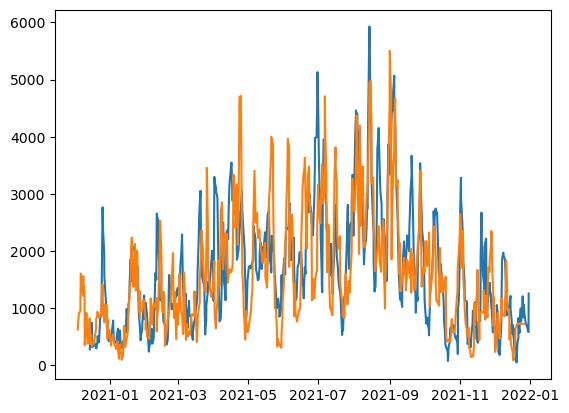

In [22]:
PRtovs2021_sjcl = sectransp_2018['forpr_sjc3'][5][1095:]
PRtovs2021_sjcbl = sectransp_2018['backvs_sjc3'][5][1095:]

PRtovs2021_sjc = pd.Series(PRtovs2021_sjcl,index=datelist_vs_prtovs[1095:])
PRtovs2021_sjcb = pd.Series(PRtovs2021_sjcbl,index=datelist_vs[1095:])

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2021_sjc,age_2018['forpr_sjc3'][5][1095:],datelist_vs_prtovs[1095:],base,factor)
        dfr2 = shift_time(PRtovs2021_sjcb,age_2018['backvs_sjc3'][5][1095:],datelist_vs[1095:],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
            
i_base,i_factor = np.where(corr_arr==np.max(corr_arr))

base = base_arr[i_base]
factor = factor_arr[i_factor]

print(base,factor)

PRtovs2021_sjc_sh = shift_time(PRtovs2021_sjc,age_2018['forpr_sjc3'][5][1095:],datelist_vs_prtovs[1095:],base[0],factor[0])
PRtovs2021_sjcb_sh = shift_time(PRtovs2021_sjcb,age_2018['backvs_sjc3'][5][1095:],datelist_vs[1095:],-base[0],-factor[0])

PRtovs2021_sjc_m,PRtovs2021_sjcb_m,c,PRtovs2021_sjc_avg = merge(PRtovs2021_sjc_sh,PRtovs2021_sjcb_sh)
print(c)

plt.plot(PRtovs2021_sjc_m.Transport)
plt.plot(PRtovs2021_sjcb_m.Transport)

#### Saving files as pdf

In [24]:
# PRtovs2018_sjc_avg.dropna().to_csv('combined2timeseries/PRtovs2018_sjc_avg.csv',index_label='Date')
PRtovs2019_sjc_avg.dropna().to_csv('combined2timeseries/PRtovs2019_sjc_avg.csv',index_label='Date')
PRtovs2020_sjc_avg.dropna().to_csv('combined2timeseries/PRtovs2020_sjc_avg.csv',index_label='Date')
PRtovs2021_sjc_avg.dropna().to_csv('combined2timeseries/PRtovs2021_sjc_avg.csv',index_label='Date')
PRtoVS_sjc_avg.dropna().to_csv('combined2timeseries/PRtoVS_sjc_avg.csv',index_label='Date')